##Malaria Detection using Blood Cell Images Project

##Done By: Ashwath Bala S

# Table of Contents
 1. Problem Statment
 2. Understanding Folder Structure
 3. Understanding Data Set
 4. Data Preparation
 5. Method 1 : Pixel values as features
 6. Model 1 : Model building using Pixel Features
 7. Method 2 : HOG Features
 8. Model 2 : Model building using HOG Features

##1. Problem Statement
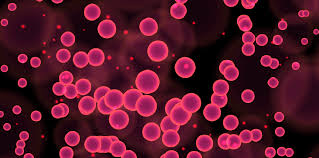


Malaria is one of the deadliest diseases. It is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.


However, Malaria diagnosis involves close examination of the blood smear at 100x magnification. This is followed by a manual counting process wherein experts count the number of Red blood cells impacted by parasites. Automatic detection of Malaria from blood smear image is a scalable solution and can save a lot of hours for healthcare industry going a long way in our battle against this deadly disease. In this project, we try to identify from blood smears using deep learning to predict whether the sample is taken from an infected person.

##2. Understanding the Folder Structure

Let us try to understand the folder structure of the dataset first before we plunge in and have a look at the dataset and blood smear images.

In [1]:
from google.colab import drive
import shutil
import zipfile
import os

# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/My\ Drive/cell_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_36.png  
 extracting: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_37.png  
 extracting: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_38.png  
 extracting: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_39.png  
 extracting: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_4.png  
 extracting: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_40.png  
 extracting: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_41.png  
 extracting: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_42.png  
  inflating: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_43.png  
 extracting: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_44.png  
 extracting: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_45.png  
 extracting: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_46.png  
  inflating: cell_images/C68P29N_ThinF_IMG_20150819_134830_cell_47.png  
 

In [4]:
#Storing the base directory
import os

base_dir = os.path.join('./cell_images')

In [3]:
!ls

cell_images  drive  Malaria_Detection_Project_Dataset.csv  sample_data


The cell images folder contains all the images of the dataset and the file train.csv contain image names belonging to dataset and their corresponding labels i.e. Parasitized/Uninfected.
Now lets see the names of images present in our dataset.

# 3. Understanding Data Set

First of all, let's set the base directory for reading images as all the images of the dataset are present in this directory.

Now lets import the train.csv and look at its contents.

In [5]:
import numpy as np
import pandas as pd

In [6]:
train_df = pd.read_csv('Malaria_Detection_Project_Dataset.csv')
train_df.shape

(19290, 2)

In [7]:
train_df.head()

,filename,label
0,C50P11thinF_IMG_20150724_114951_cell_148.png,malaria
1,C112P73ThinF_IMG_20150930_131659_cell_94.png,healthy
2,C59P20thinF_IMG_20150803_111333_cell_144.png,malaria
3,C158P119ThinF_IMG_20151115_181136_cell_202.png,malaria
4,C81P42ThinF_IMG_20150817_120524_cell_190.png,malaria


In [8]:
# Understanding the distribution of both classes in the training data set
train_df['label'].value_counts()

label
malaria    9645
healthy    9645
Name: count, dtype: int64

From the above cell we can observe that our train set consists of equal samples of both the classes thus we will not face any problem due to class imbalance in the dataset.


<Figure size 1500x1500 with 0 Axes>

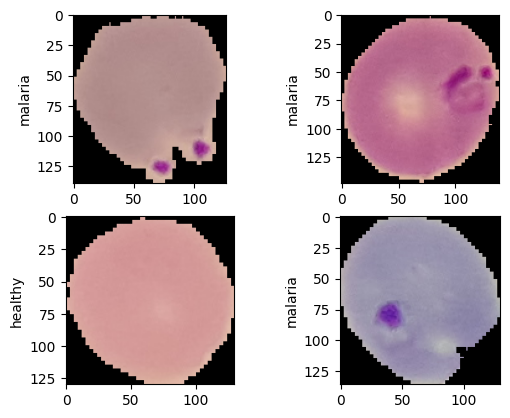

In [9]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

plt.figure(figsize=(15,15))
fig, ax = plt.subplots(nrows=2, ncols=2)

for i in range(2):
    for j in range(2):
        #Reading files after concatenating file name with folder path
        image = imread(os.path.join(base_dir,train_df["filename"][i+2*j]))
        #showing some images of the dataset
        ax[i,j].imshow(image)
        ax[i,j].set_ylabel(train_df["label"][i+2*j])

# 4. Data Preparation

1. Since we have textual labels for our images i.e. Parasitized/Uninfected so we will convert them to numerical labels i.e. 0/1

In [14]:
labels = np.array(train_df['label'])  # Convert to numpy array
print(labels.shape)

(19290,)


In [15]:
le.fit(labels)
encoded_labels = le.transform(labels)

2. Here we split the dataset into training and validation sets.
Training set is the subset of the dataset that is used for training and validation set is used to evaluate the performance of the model after every epoch.

In [16]:
#import required functions
from sklearn.model_selection import train_test_split

#divide the dataset into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(train_df['filename'],
                                                                    labels,
                                                                    test_size=0.2, random_state=42,shuffle=True)
#check the shapes of training and validation sets
print(train_files.shape, val_files.shape)
print(train_labels.shape,val_labels.shape)

(15432,) (3858,)
(15432,) (3858,)


In [17]:
from skimage.io import imread, imshow
from skimage.transform import resize

In [18]:
shapes = []
for i in train_df['filename']:
    image = imread(os.path.join(base_dir,i))
    shapes.append(image.shape)

print('Minimum Dimensions - ',np.min(shapes,axis=0))
print('Maximum Dimensions - ',np.max(shapes,axis=0))
print('Average Dimensions - ',np.mean(shapes,axis=0))

Minimum Dimensions -  [40 49  3]
Maximum Dimensions -  [385 364   3]
Average Dimensions -  [132.9600311  132.58335925   3.        ]


We can see that there are images of different shapes. It is recommended to have images in shape size before going ahead with modeling process and it is also dependent on which feature extractor tool, we are using.

# 5. Method 1 : Pixel Values as Features

Here, we will use pixel value as a feature to classify images in Parasitized/Uninfected images. Although, we have looked at that these images are of different shapes so we will bring all the images in same shape by resizing to 40X40. And, after that convert two dimensional matrix to one dimensional vector. So, for each images, we will have 1600 (40X40) features.

In [19]:
IMG_DIMS=(40,40)
train_features_pixel=[]

for i in train_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    features = np.reshape(image,(IMG_DIMS[0]*IMG_DIMS[1]*3))
    train_features_pixel.append(features)

train_features_pixel = np.array(train_features_pixel)

In [20]:
train_features_pixel.shape

(15432, 4800)

In [21]:
IMG_DIMS=(40,40)
val_features_pixel=[]

for i in val_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    features = np.reshape(image,(IMG_DIMS[0]*IMG_DIMS[1]*3))
    val_features_pixel.append(features)

val_features_pixel = np.array(val_features_pixel)

In [22]:
val_features_pixel.shape

(3858, 4800)

# 6. Model 1 : Model building using Pixel Features

## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#training the Logistic model
clf_lr_pixel = LogisticRegression()
clf_lr_pixel.fit(train_features_pixel,train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
preditions_train = clf_lr_pixel.predict(train_features_pixel)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_lr_pixel.predict(val_features_pixel)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  73.05598755832037 %
Validation: Model Accuracy -  68.11819595645412 %


## Linear SVM

In [25]:
from sklearn.svm import LinearSVC

#training the Logistic model
clf_svc_pixel = LinearSVC(random_state=102)
clf_svc_pixel.fit(train_features_pixel,train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=102)

In [26]:
preditions_train = clf_svc_pixel.predict(train_features_pixel)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_svc_pixel.predict(val_features_pixel)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  77.77993779160187 %
Validation: Model Accuracy -  68.01451529289787 %


# 7. Method 2 : HOG Features

Our image size should be in 64X128(Width X Height) shape to extract HOG features from images. We will first change image shape size to 64X128 first and then extract HOG features.

In [27]:
from skimage.feature import hog

In [28]:
#Showing example of one image first
index= np.random.randint(0,1000)

image = imread(os.path.join(base_dir,train_files.iloc[index]))
IMG_DIMS = (128,64) # SkIMAGE takes input in HEIGHT X WIDTH format
image1 = resize(image,IMG_DIMS)
#calculating HOG features
features, hog_image = hog(image1, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

<ipython-input-28-8b95b585ffe3>:8: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image1, orientations=9, pixels_per_cell=(8, 8),


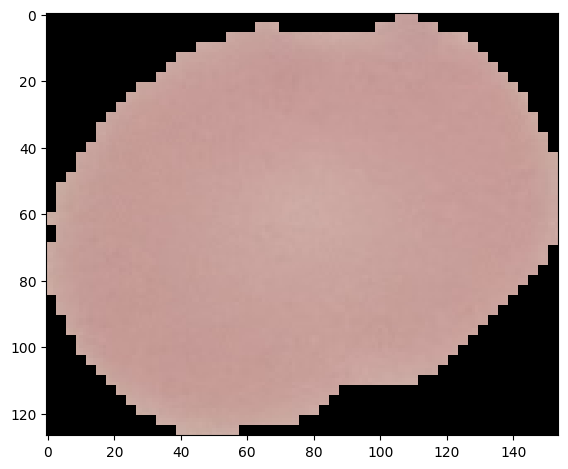

In [29]:
#Original Image
imshow(image)

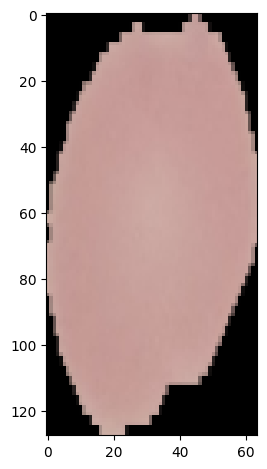

In [30]:
#After Resize
imshow(image1)

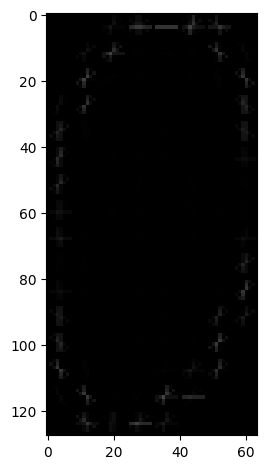

In [31]:
#Image with HOG Image (Look At the Edges)
imshow(hog_image)

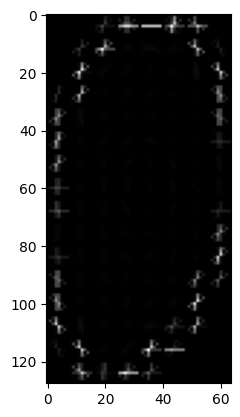

In [32]:
#Highlighting the HOG image using Matplotlib
import matplotlib.pyplot as plt
plt.imshow(hog_image, cmap="gray")

In [33]:
#Shape of HOG Feature Vector
features.shape

(3780,)

## Calculating HOG features for both training and Validation images

In [34]:
IMG_DIMS = (128,64)

#For Training Images

train_features_hog = []
for i in train_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    #calculating HOG features
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    hog_features = np.reshape(features,(features.shape[0]))
    train_features_hog.append(hog_features)

train_features_hog = np.array(train_features_hog)

#For Validation Images

val_features_hog = []
for i in val_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    #calculating HOG features
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    hog_features = np.reshape(features,(features.shape[0]))
    val_features_hog.append(hog_features)

val_features_hog = np.array(val_features_hog)

#checking the shape of the final lists after reading all the images
train_features_hog.shape, val_features_hog.shape

<ipython-input-34-28f4da4e631b>:10: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
<ipython-input-34-28f4da4e631b>:24: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),


((15432, 3780), (3858, 3780))

# 8. Model 2 : Model building using HOG Features

## Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#training the Logistic model
clf_lr_hog = LogisticRegression()
clf_lr_hog.fit(train_features_hog,train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [36]:
preditions_train = clf_lr_hog.predict(train_features_hog)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_lr_hog.predict(val_features_hog)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  89.34681181959564 %
Validation: Model Accuracy -  81.5966822187662 %


## Linear SVM

In [37]:
from sklearn.svm import LinearSVC

#training the Logistic model
clf_svc_hog = LinearSVC()
clf_svc_hog.fit(train_features_hog,train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [38]:
preditions_train = clf_svc_hog.predict(train_features_hog)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_svc_hog.predict(val_features_hog)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  92.26283048211509 %
Validation: Model Accuracy -  80.3784344219803 %


##In this Project, we have built Machine Learning Models to detect Malaria from Blood Cell Images using Pixel Values as Features and HOG Features